In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import RMSprop
from keras.models import load_model
from keras import backend as K
import matplotlib.pyplot as plt
import csv
import numpy as np

Using TensorFlow backend.


In [2]:
def load_shadow_train_data(shadow_train_files):
    shadow_train_x = []
    shadow_train_y = []
    for i in range(0,len(shadow_train_files)):
        
        shadow_train_sub = np.loadtxt('model\\'+shadow_train_files[i],delimiter=',')
        shadow_train_sub_x = shadow_train_sub[:,0:10]
        shadow_train_sub_y = shadow_train_sub[:,10]
        shadow_train_sub_x = shadow_train_sub_x.reshape(-1,10)[i*2000:i*2000+4000]
        shadow_train_sub_y = shadow_train_sub_y.reshape(-1,1)[i*2000:i*2000+4000]

        
        if i == 0:
            shadow_train_x = shadow_train_sub_x
            shadow_train_y = shadow_train_sub_y
        else:
            shadow_train_x = np.concatenate((shadow_train_x,shadow_train_sub_x), axis=0)
            shadow_train_y = np.concatenate((shadow_train_y,shadow_train_sub_y), axis=0)
    return shadow_train_x,shadow_train_y


def load_diff_percent_shadow_test(shadow_test_x,shadow_test_y,label_one_index):
    shadow_test_x = shadow_test_x.reshape(-1,10)
    shadow_test_y  = shadow_test_y.reshape(-1,1)
    
    diff_percent_shadow_test = []
    rate_labale_one = 0.2
    r_chunck = int(4000 * rate_labale_one)
    l_chunck = int(4000 * (1 - rate_labale_one))
    
    if label_one_index >= 4000 and label_one_index<= 10000:
        #0%
        diff_percent_shadow_test.append(shadow_test_x[0:4000])
        diff_percent_shadow_test.append(shadow_test_y[0:4000])
        
        #20%
        diff_percent_shadow_test.append(shadow_test_x[label_one_index-l_chunck:label_one_index+r_chunck])
        diff_percent_shadow_test.append(shadow_test_y[label_one_index-l_chunck:label_one_index+r_chunck])
        
        #50
        diff_percent_shadow_test.append(shadow_test_x[label_one_index-2000:label_one_index+2000])
        diff_percent_shadow_test.append(shadow_test_y[label_one_index-2000:label_one_index+2000])
        
        #100
        diff_percent_shadow_test.append(shadow_test_x[label_one_index:label_one_index+2000])
        diff_percent_shadow_test.append(shadow_test_y[label_one_index:label_one_index+2000])
        
    return diff_percent_shadow_test

In [3]:
#train_data
shadow_train_files = ['test_shadow1.csv','test_shadow2.csv','test_shadow3.csv','test_shadow4.csv','test_shadow5.csv']
shadow_train_x,shadow_train_y = load_shadow_train_data(shadow_train_files)
print(shadow_train_x.shape)
print(shadow_train_y.shape)

#test_data
shadow_test = np.loadtxt('model\\test_shadow5.csv',delimiter=',')
shadow_test_x = shadow_test[:,0:10]
shadow_test_y = shadow_test[:,10]

#10000~12000  label=1  other=0
diff_percent_shadow_test = load_diff_percent_shadow_test(shadow_test_x,shadow_test_y,10000)

for test in diff_percent_shadow_test:
    print(test.shape)

(20000, 10)
(20000, 1)
(4000, 10)
(4000, 1)
(4000, 10)
(4000, 1)
(4000, 10)
(4000, 1)
(2000, 10)
(2000, 1)


In [4]:
# # first train attack_model

# model = Sequential()
# model.add(Dense(16, input_dim=10, activation='relu')) #把dense=1改为20
# model.add(Dropout(0.5))
# model.add(Dense(8,activation='relu')) #没有input 表示隐层神经元
# model.add(Dropout(0.5))
# model.add(Dense(1,activation='sigmoid')) #输出1维，表示是输出层神经元

# model.compile(loss='binary_crossentropy',
#              optimizer=RMSprop(),
#              metrics=['accuracy']),
# history = model.fit(shadow_train_x, shadow_train_y,nb_epoch=20, batch_size=64,verbose=1)

# # first evaluate attack_model
# score = model.evaluate(shadow_test_x, shadow_test_y,batch_size=64, verbose=1)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])
# predictions = model.predict_classes(shadow_test_x)

# import matplotlib.pyplot as plt
# plt.plot(predictions)

# model.save('model\\attack_model_temp.h5')

In [5]:
def diff_percent_evaluate(diff_percent_shadow_test):
    percent = [0,20,50,100]
    for i in range(0,len(percent)):
        score = attack_model.evaluate(diff_percent_shadow_test[i * 2], diff_percent_shadow_test[i * 2 + 1],batch_size=64, verbose=1)
        print('percent:',percent[i],'%')
        print('Test score:', score[0])
        print('Test accuracy:', score[1],'\n')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
4000/4000 [==============================] - 0s 16us/step
percent: 0 %
Test score: 0.6881923270225525
Test accuracy: 0.754 

4000/4000 [==============================] - 0s 8us/step
percent: 20 %
Test score: 0.6901876316070557
Test accuracy: 0.649 

4000/4000 [==============================] - 0s 8us/step
percent: 50 %
Test score: 0.6930242118835449
Test accuracy: 0.5095 

2000/2000 [==============================] - 0s 8us/step
percent: 100 %
Test score: 0.6977711911201477
Test accuracy: 0.276 



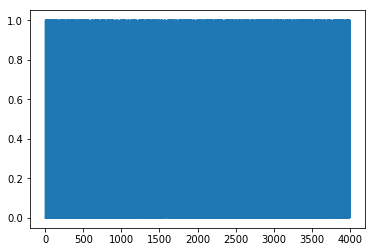

In [6]:
#加载attack模型，并用验证集评估
attack_model = load_model('model\\attack_model_temp.h5')
diff_percent_evaluate(diff_percent_shadow_test)

#预测的label图
predictions = attack_model.predict_classes(diff_percent_shadow_test[4])
plt.plot(predictions)

In [7]:
def load_mnist_data():
    num_classes = 10
    # input image dimensions
    img_rows, img_cols = 28, 28
    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    print('x_train shape:', x_train.shape)
    print('x_test shape:', x_test.shape)
    return x_train,y_train,x_test,y_test


def load_distillation_data(x_distillation):
    
    for i in range(0,10):
    distil=[]
        distil.append([])
    for i in range(0,len(x_distillation)):
        index = i % 10
        distil[index].append(x_distillation[i])
    return  distil

def load_shadow_model(root,shadows):
    shadow_models=[]
    for shadow in shadows:
        path = root + shadow
        model = load_model(path)
        shadow_models.append(model)
    return shadow_models

def load_shadow_train_data(shadow_x):
    shadow_train_x = []
    shadow_train_y = []
    for i in range(0,len(shadow_x)):
        
        shadow_train_sub_x = shadow_x[i][i*2000:i*2000+4000]
        shadow_train_sub_y = np.zeros((2000,1))
        shadow_train_sub_y = np.concatenate((shadow_train_sub_y,np.ones((2000,1))), axis=0)

        if i == 0:
            shadow_train_x = shadow_train_sub_x
            shadow_train_y = shadow_train_sub_y
        else:
            shadow_train_x = np.concatenate((shadow_train_x,shadow_train_sub_x), axis=0)
            
            shadow_train_sub_y = np.zeros((2000,1))
            shadow_train_sub_y = np.concatenate((shadow_train_sub_y,np.ones((2000,1))), axis=0)
            shadow_train_y = np.concatenate((shadow_train_y,shadow_train_sub_y), axis=0)
    return shadow_train_x,shadow_train_y

In [8]:
x_train,y_train,x_test,y_test = load_mnist_data()
x_distillation = np.concatenate((x_train,x_test), axis=0)
print('x_distillation shape:', x_distillation.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
x_distillation shape: (70000, 28, 28, 1)


In [9]:
#加载蒸馏数据
distil_data = load_distillation_data(x_distillation)

print(len(distil_data))
print(len(distil_data[0]))

distil_data = np.array(distil_data)
print(type(distil_data[0]))

10
7000
<class 'numpy.ndarray'>


In [10]:
#步骤6，过一遍target得到软标签
target_model = load_model('model\\model_target.h5')

In [11]:
#distiul_index 1~10 对应 distil_data 0~9
distil_index = 5

In [12]:
#10次蒸馏的真正标签都是这样
label_membership_temp = np.ones((2000,1))
label_membership_temp = np.concatenate((label_membership_temp,np.zeros((5000,1))), axis=0)
print(label_membership_temp.shape)

(7000, 1)


In [13]:
root = 'model\\'
shadows_list = ['shadow1_T_1.h5','shadow2_T_1.h5','shadow3_T_1.h5','shadow4_T_1.h5','shadow5_T_1.h5']

models = load_shadow_model(root,shadows_list)

7000/7000 [==============================] - 0s 11us/step
Test loss: 0.6912355588504246
Test accuracy: 0.592571428503309
7000/7000 [==============================] - 0s 11us/step
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]
(1870, 28, 28, 1)
(1870, 10)
(1870, 1)
{'fn': 3639, 'tp': 509, 'tn': 1491, 'fp': 1361}


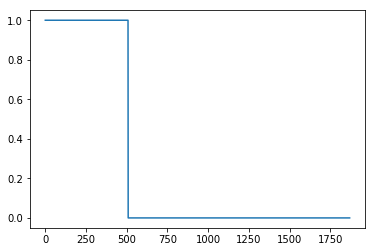

Epoch 1/100
1870/1870 [==============================] - 1s 284us/step - loss: 0.0351 - acc: 0.9947
Epoch 2/100
1870/1870 [==============================] - 0s 193us/step - loss: 0.0237 - acc: 0.9984
Epoch 3/100
1870/1870 [==============================] - 0s 198us/step - loss: 0.0210 - acc: 0.9989
Epoch 4/100
1870/1870 [==============================] - 0s 192us/step - loss: 0.0204 - acc: 0.9989
Epoch 5/100
1870/1870 [==============================] - 0s 193us/step - loss: 0.0199 - acc: 0.9995
Epoch 6/100
1870/1870 [==============================] - 0s 202us/step - loss: 0.0197 - acc: 0.9995
Epoch 7/100
1870/1870 [==============================] - 0s 192us/step - loss: 0.0198 - acc: 0.9995
Epoch 8/100
1870/1870 [==============================] - 0s 194us/step - loss: 0.0183 - acc: 1.0000
Epoch 9/100
1870/1870 [==============================] - 0s 194us/step - loss: 0.0196 - acc: 0.9989
Epoch 10/100
1870/1870 [==============================] - 0s 200us/step - loss: 0.0179 - acc: 0.9995

1870/1870 [==============================] - 0s 227us/step - loss: 0.0164 - acc: 0.9995
Epoch 83/100
1870/1870 [==============================] - 0s 229us/step - loss: 0.0167 - acc: 1.0000
Epoch 84/100
1870/1870 [==============================] - 0s 215us/step - loss: 0.0164 - acc: 0.9995
Epoch 85/100
1870/1870 [==============================] - 0s 220us/step - loss: 0.0165 - acc: 1.0000
Epoch 86/100
1870/1870 [==============================] - 0s 217us/step - loss: 0.0164 - acc: 0.9995
Epoch 87/100
1870/1870 [==============================] - 0s 217us/step - loss: 0.0166 - acc: 1.0000
Epoch 88/100
1870/1870 [==============================] - 0s 218us/step - loss: 0.0170 - acc: 0.9995
Epoch 89/100
1870/1870 [==============================] - 0s 217us/step - loss: 0.0163 - acc: 0.9995
Epoch 90/100
1870/1870 [==============================] - 0s 221us/step - loss: 0.0163 - acc: 1.0000
Epoch 91/100
1870/1870 [==============================] - 0s 234us/step - loss: 0.0165 - acc: 1.0000
Epo

1870/1870 [==============================] - 0s 219us/step - loss: 0.0166 - acc: 1.0000
Epoch 64/100
1870/1870 [==============================] - 0s 211us/step - loss: 0.0173 - acc: 0.9995
Epoch 65/100
1870/1870 [==============================] - 0s 217us/step - loss: 0.0165 - acc: 0.9995
Epoch 66/100
1870/1870 [==============================] - 0s 223us/step - loss: 0.0163 - acc: 1.0000
Epoch 67/100
1870/1870 [==============================] - 0s 217us/step - loss: 0.0173 - acc: 0.9995
Epoch 68/100
1870/1870 [==============================] - 0s 218us/step - loss: 0.0169 - acc: 0.9995
Epoch 69/100
1870/1870 [==============================] - 0s 210us/step - loss: 0.0166 - acc: 0.9995
Epoch 70/100
1870/1870 [==============================] - 0s 217us/step - loss: 0.0164 - acc: 1.0000
Epoch 71/100
1870/1870 [==============================] - 0s 215us/step - loss: 0.0173 - acc: 0.9989
Epoch 72/100
1870/1870 [==============================] - 0s 217us/step - loss: 0.0162 - acc: 0.9995
Epo

Epoch 44/100
1870/1870 [==============================] - 0s 226us/step - loss: 0.0169 - acc: 0.9989
Epoch 45/100
1870/1870 [==============================] - 0s 210us/step - loss: 0.0168 - acc: 1.0000
Epoch 46/100
1870/1870 [==============================] - 0s 217us/step - loss: 0.0167 - acc: 0.9995
Epoch 47/100
1870/1870 [==============================] - 0s 220us/step - loss: 0.0167 - acc: 0.9995
Epoch 48/100
1870/1870 [==============================] - 0s 209us/step - loss: 0.0166 - acc: 1.0000
Epoch 49/100
1870/1870 [==============================] - 0s 210us/step - loss: 0.0169 - acc: 0.9995
Epoch 50/100
1870/1870 [==============================] - 1s 271us/step - loss: 0.0165 - acc: 0.9995
Epoch 51/100
1870/1870 [==============================] - 0s 220us/step - loss: 0.0174 - acc: 0.9989
Epoch 52/100
1870/1870 [==============================] - 0s 227us/step - loss: 0.0164 - acc: 1.0000
Epoch 53/100
1870/1870 [==============================] - 0s 217us/step - loss: 0.0172 - ac

1870/1870 [==============================] - 0s 192us/step - loss: 0.0174 - acc: 0.9995
Epoch 25/100
1870/1870 [==============================] - 0s 184us/step - loss: 0.0172 - acc: 1.0000
Epoch 26/100
1870/1870 [==============================] - 0s 229us/step - loss: 0.0183 - acc: 0.9989
Epoch 27/100
1870/1870 [==============================] - 0s 200us/step - loss: 0.0181 - acc: 0.9989
Epoch 28/100
1870/1870 [==============================] - 0s 194us/step - loss: 0.0170 - acc: 1.0000
Epoch 29/100
1870/1870 [==============================] - 0s 184us/step - loss: 0.0168 - acc: 1.0000
Epoch 30/100
1870/1870 [==============================] - 0s 184us/step - loss: 0.0176 - acc: 0.9989
Epoch 31/100
1870/1870 [==============================] - 0s 195us/step - loss: 0.0168 - acc: 0.9995
Epoch 32/100
1870/1870 [==============================] - 0s 184us/step - loss: 0.0175 - acc: 0.9995
Epoch 33/100
1870/1870 [==============================] - 0s 192us/step - loss: 0.0169 - acc: 0.9995
Epo

1870/1870 [==============================] - 0s 192us/step - loss: 0.0210 - acc: 0.9989
Epoch 6/100
1870/1870 [==============================] - 0s 192us/step - loss: 0.0190 - acc: 0.9989
Epoch 7/100
1870/1870 [==============================] - 0s 185us/step - loss: 0.0204 - acc: 0.9989
Epoch 8/100
1870/1870 [==============================] - 0s 184us/step - loss: 0.0181 - acc: 0.9995
Epoch 9/100
1870/1870 [==============================] - 0s 192us/step - loss: 0.0189 - acc: 0.9995
Epoch 10/100
1870/1870 [==============================] - 0s 185us/step - loss: 0.0182 - acc: 1.0000
Epoch 11/100
1870/1870 [==============================] - 0s 184us/step - loss: 0.0182 - acc: 0.9989
Epoch 12/100
1870/1870 [==============================] - 0s 194us/step - loss: 0.0184 - acc: 0.9995
Epoch 13/100
1870/1870 [==============================] - 0s 215us/step - loss: 0.0182 - acc: 0.9995
Epoch 14/100
1870/1870 [==============================] - 0s 192us/step - loss: 0.0182 - acc: 0.9989
Epoch 1

1870/1870 [==============================] - 0s 194us/step - loss: 0.0168 - acc: 0.9989
Epoch 87/100
1870/1870 [==============================] - 0s 186us/step - loss: 0.0169 - acc: 0.9995
Epoch 88/100
1870/1870 [==============================] - 0s 196us/step - loss: 0.0169 - acc: 0.9995
Epoch 89/100
1870/1870 [==============================] - 0s 186us/step - loss: 0.0163 - acc: 1.0000
Epoch 90/100
1870/1870 [==============================] - 0s 185us/step - loss: 0.0168 - acc: 1.0000
Epoch 91/100
1870/1870 [==============================] - 0s 186us/step - loss: 0.0164 - acc: 0.9995
Epoch 92/100
1870/1870 [==============================] - 0s 192us/step - loss: 0.0160 - acc: 1.0000
Epoch 93/100
1870/1870 [==============================] - 0s 186us/step - loss: 0.0163 - acc: 0.9995
Epoch 94/100
1870/1870 [==============================] - 0s 188us/step - loss: 0.0170 - acc: 0.9995
Epoch 95/100
1870/1870 [==============================] - 0s 192us/step - loss: 0.0165 - acc: 1.0000
Epo

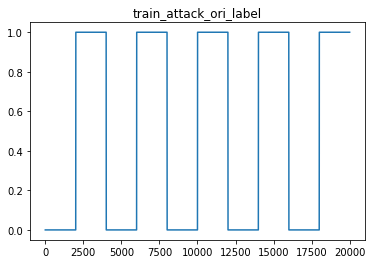

Epoch 1/20
   64/20000 [..............................] - ETA: 53s - loss: 0.6933 - acc: 0.4688

D:\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:87: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


20000/20000 [==============================] - 0s 23us/step - loss: 0.6934 - acc: 0.4971
Epoch 2/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6932 - acc: 0.5018
Epoch 3/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6932 - acc: 0.5000
Epoch 4/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6932 - acc: 0.5029
Epoch 5/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6932 - acc: 0.5006
Epoch 6/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6932 - acc: 0.5004
Epoch 7/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6932 - acc: 0.4998
Epoch 8/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6932 - acc: 0.4997
Epoch 9/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6932 - acc: 0.5017
Epoch 10/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6931 - acc: 0.5001
Epoch 11/2

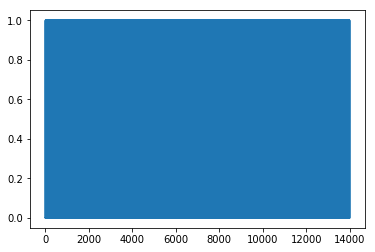

7000/7000 [==============================] - 0s 12us/step
Test loss: 0.6934090676307678
Test accuracy: 0.5914285713604518
7000/7000 [==============================] - 0s 6us/step
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]
(2004, 28, 28, 1)
(2004, 10)
(2004, 1)
{'fn': 3568, 'tp': 572, 'tn': 1428, 'fp': 1432}


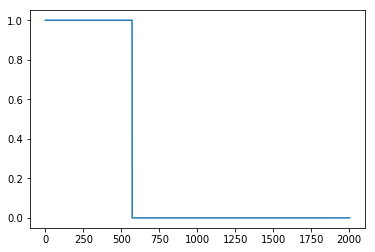

Epoch 1/100
2004/2004 [==============================] - 0s 191us/step - loss: 2.4760 - acc: 0.2989
Epoch 2/100
2004/2004 [==============================] - 0s 187us/step - loss: 1.2035 - acc: 0.3847
Epoch 3/100
2004/2004 [==============================] - 0s 189us/step - loss: 1.1412 - acc: 0.4032
Epoch 4/100
2004/2004 [==============================] - 0s 187us/step - loss: 1.0979 - acc: 0.4311
Epoch 5/100
2004/2004 [==============================] - 0s 196us/step - loss: 1.0642 - acc: 0.4701
Epoch 6/100
2004/2004 [==============================] - 0s 188us/step - loss: 1.0306 - acc: 0.5030
Epoch 7/100
2004/2004 [==============================] - 0s 187us/step - loss: 0.9976 - acc: 0.5225
Epoch 8/100
2004/2004 [==============================] - 0s 189us/step - loss: 0.9581 - acc: 0.5544
Epoch 9/100
2004/2004 [==============================] - 0s 189us/step - loss: 0.9273 - acc: 0.5594
Epoch 10/100
2004/2004 [==============================] - 0s 194us/step - loss: 0.9084 - acc: 0.5843

2004/2004 [==============================] - 0s 196us/step - loss: 0.0604 - acc: 0.9865
Epoch 83/100
2004/2004 [==============================] - 0s 195us/step - loss: 0.0529 - acc: 0.9910
Epoch 84/100
2004/2004 [==============================] - 0s 192us/step - loss: 0.0599 - acc: 0.9855
Epoch 85/100
2004/2004 [==============================] - 0s 191us/step - loss: 0.0599 - acc: 0.9850
Epoch 86/100
2004/2004 [==============================] - 0s 187us/step - loss: 0.0543 - acc: 0.9870
Epoch 87/100
2004/2004 [==============================] - 0s 199us/step - loss: 0.0517 - acc: 0.9900
Epoch 88/100
2004/2004 [==============================] - 0s 190us/step - loss: 0.0559 - acc: 0.9905
Epoch 89/100
2004/2004 [==============================] - 0s 190us/step - loss: 0.0582 - acc: 0.9880
Epoch 90/100
2004/2004 [==============================] - 0s 196us/step - loss: 0.0599 - acc: 0.9885
Epoch 91/100
2004/2004 [==============================] - 0s 187us/step - loss: 0.0483 - acc: 0.9935
Epo

2004/2004 [==============================] - 0s 194us/step - loss: 0.0924 - acc: 0.9741
Epoch 64/100
2004/2004 [==============================] - 0s 188us/step - loss: 0.0790 - acc: 0.9830
Epoch 65/100
2004/2004 [==============================] - 0s 187us/step - loss: 0.0813 - acc: 0.9805
Epoch 66/100
2004/2004 [==============================] - 0s 191us/step - loss: 0.0817 - acc: 0.9785
Epoch 67/100
2004/2004 [==============================] - 0s 210us/step - loss: 0.0882 - acc: 0.9736
Epoch 68/100
2004/2004 [==============================] - 0s 190us/step - loss: 0.0746 - acc: 0.9825
Epoch 69/100
2004/2004 [==============================] - 0s 234us/step - loss: 0.0743 - acc: 0.9825
Epoch 70/100
2004/2004 [==============================] - 0s 209us/step - loss: 0.0790 - acc: 0.9805
Epoch 71/100
2004/2004 [==============================] - 0s 195us/step - loss: 0.0731 - acc: 0.9855
Epoch 72/100
2004/2004 [==============================] - 0s 195us/step - loss: 0.0781 - acc: 0.9815
Epo

2004/2004 [==============================] - 0s 198us/step - loss: 0.1476 - acc: 0.9581
Epoch 45/100
2004/2004 [==============================] - 0s 187us/step - loss: 0.1472 - acc: 0.9591
Epoch 46/100
2004/2004 [==============================] - 0s 189us/step - loss: 0.1504 - acc: 0.9536
Epoch 47/100
2004/2004 [==============================] - 0s 195us/step - loss: 0.1391 - acc: 0.9581
Epoch 48/100
2004/2004 [==============================] - 0s 188us/step - loss: 0.1367 - acc: 0.9606
Epoch 49/100
2004/2004 [==============================] - 0s 190us/step - loss: 0.1256 - acc: 0.9656
Epoch 50/100
2004/2004 [==============================] - 0s 185us/step - loss: 0.1283 - acc: 0.9681
Epoch 51/100
2004/2004 [==============================] - 0s 196us/step - loss: 0.1152 - acc: 0.9691
Epoch 52/100
2004/2004 [==============================] - 0s 188us/step - loss: 0.1160 - acc: 0.9676
Epoch 53/100
2004/2004 [==============================] - 0s 194us/step - loss: 0.1135 - acc: 0.9686
Epo

2004/2004 [==============================] - 0s 188us/step - loss: 0.4041 - acc: 0.8553
Epoch 26/100
2004/2004 [==============================] - 0s 197us/step - loss: 0.3700 - acc: 0.8638
Epoch 27/100
2004/2004 [==============================] - 0s 187us/step - loss: 0.3624 - acc: 0.8703
Epoch 28/100
2004/2004 [==============================] - 0s 195us/step - loss: 0.3406 - acc: 0.8837
Epoch 29/100
2004/2004 [==============================] - 0s 188us/step - loss: 0.3192 - acc: 0.8872
Epoch 30/100
2004/2004 [==============================] - 0s 195us/step - loss: 0.2928 - acc: 0.8992
Epoch 31/100
2004/2004 [==============================] - 0s 189us/step - loss: 0.2715 - acc: 0.9087
Epoch 32/100
2004/2004 [==============================] - 0s 188us/step - loss: 0.2585 - acc: 0.9157
Epoch 33/100
2004/2004 [==============================] - 0s 187us/step - loss: 0.2513 - acc: 0.9122
Epoch 34/100
2004/2004 [==============================] - 0s 189us/step - loss: 0.2313 - acc: 0.9276
Epo

2004/2004 [==============================] - 0s 195us/step - loss: 1.0864 - acc: 0.4446
Epoch 6/100
2004/2004 [==============================] - 0s 195us/step - loss: 1.0394 - acc: 0.4870
Epoch 7/100
2004/2004 [==============================] - 0s 195us/step - loss: 1.0146 - acc: 0.5125
Epoch 8/100
2004/2004 [==============================] - 0s 187us/step - loss: 0.9713 - acc: 0.5404
Epoch 9/100
2004/2004 [==============================] - 0s 195us/step - loss: 0.9394 - acc: 0.5649
Epoch 10/100
2004/2004 [==============================] - 0s 187us/step - loss: 0.9165 - acc: 0.5808
Epoch 11/100
2004/2004 [==============================] - 0s 195us/step - loss: 0.8778 - acc: 0.5933
Epoch 12/100
2004/2004 [==============================] - 0s 187us/step - loss: 0.8507 - acc: 0.6128
Epoch 13/100
2004/2004 [==============================] - 0s 201us/step - loss: 0.8147 - acc: 0.6417
Epoch 14/100
2004/2004 [==============================] - 0s 192us/step - loss: 0.7913 - acc: 0.6617
Epoch 1

2004/2004 [==============================] - 0s 196us/step - loss: 0.0612 - acc: 0.9895
Epoch 86/100
2004/2004 [==============================] - 0s 187us/step - loss: 0.0571 - acc: 0.9920
Epoch 87/100
2004/2004 [==============================] - 0s 232us/step - loss: 0.0530 - acc: 0.9920
Epoch 88/100
2004/2004 [==============================] - 0s 210us/step - loss: 0.0513 - acc: 0.9925
Epoch 89/100
2004/2004 [==============================] - 0s 187us/step - loss: 0.0514 - acc: 0.9920
Epoch 90/100
2004/2004 [==============================] - 0s 196us/step - loss: 0.0529 - acc: 0.9905
Epoch 91/100
2004/2004 [==============================] - 0s 193us/step - loss: 0.0538 - acc: 0.9915
Epoch 92/100
2004/2004 [==============================] - 0s 189us/step - loss: 0.0551 - acc: 0.9910
Epoch 93/100
2004/2004 [==============================] - 0s 195us/step - loss: 0.0480 - acc: 0.9920
Epoch 94/100
2004/2004 [==============================] - 0s 195us/step - loss: 0.0584 - acc: 0.9875
Epo

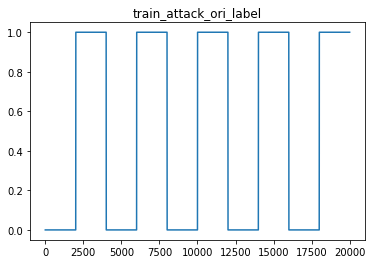

Epoch 1/20
20000/20000 [==============================] - 0s 15us/step - loss: 0.6932 - acc: 0.5048
Epoch 2/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6932 - acc: 0.4986
Epoch 3/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6931 - acc: 0.4976
Epoch 4/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6932 - acc: 0.5002
Epoch 5/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6931 - acc: 0.5020
Epoch 6/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6932 - acc: 0.5008
Epoch 7/20
20000/20000 [==============================] - 0s 12us/step - loss: 0.6932 - acc: 0.5010
Epoch 8/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6933 - acc: 0.4932
Epoch 9/20
20000/20000 [==============================] - 0s 14us/step - loss: 0.6931 - acc: 0.5023
Epoch 10/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6931 - acc: 0.5001

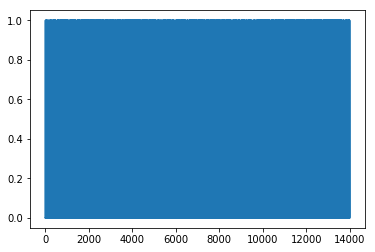

7000/7000 [==============================] - 0s 12us/step
Test loss: 0.6911340112004961
Test accuracy: 0.6701428570747375
7000/7000 [==============================] - 0s 8us/step
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]
(697, 28, 28, 1)
(697, 10)
(697, 1)
{'fn': 4497, 'tp': 194, 'tn': 1806, 'fp': 503}


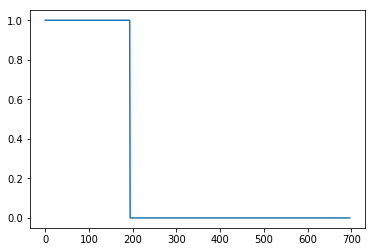

Epoch 1/100
697/697 [==============================] - 0s 228us/step - loss: 0.7874 - acc: 0.8852
Epoch 2/100
697/697 [==============================] - 0s 178us/step - loss: 0.0509 - acc: 0.9957
Epoch 3/100
697/697 [==============================] - 0s 229us/step - loss: 0.0446 - acc: 0.9986
Epoch 4/100
697/697 [==============================] - 0s 207us/step - loss: 0.0423 - acc: 1.0000
Epoch 5/100
697/697 [==============================] - 0s 209us/step - loss: 0.0420 - acc: 1.0000
Epoch 6/100
697/697 [==============================] - 0s 302us/step - loss: 0.0454 - acc: 0.9971
Epoch 7/100
697/697 [==============================] - 0s 204us/step - loss: 0.0400 - acc: 1.0000
Epoch 8/100
697/697 [==============================] - 0s 207us/step - loss: 0.0443 - acc: 0.9986
Epoch 9/100
697/697 [==============================] - 0s 199us/step - loss: 0.0439 - acc: 0.9986
Epoch 10/100
697/697 [==============================] - 0s 241us/step - loss: 0.0393 - acc: 1.0000
Epoch 11/100
697/69

697/697 [==============================] - 0s 187us/step - loss: 0.0174 - acc: 1.0000
Epoch 84/100
697/697 [==============================] - 0s 206us/step - loss: 0.0179 - acc: 1.0000
Epoch 85/100
697/697 [==============================] - 0s 210us/step - loss: 0.0175 - acc: 1.0000
Epoch 86/100
697/697 [==============================] - 0s 245us/step - loss: 0.0182 - acc: 1.0000
Epoch 87/100
697/697 [==============================] - 0s 226us/step - loss: 0.0177 - acc: 1.0000
Epoch 88/100
697/697 [==============================] - 0s 242us/step - loss: 0.0174 - acc: 1.0000
Epoch 89/100
697/697 [==============================] - 0s 288us/step - loss: 0.0176 - acc: 1.0000
Epoch 90/100
697/697 [==============================] - 0s 261us/step - loss: 0.0170 - acc: 1.0000
Epoch 91/100
697/697 [==============================] - 0s 209us/step - loss: 0.0168 - acc: 1.0000
Epoch 92/100
697/697 [==============================] - 0s 197us/step - loss: 0.0181 - acc: 1.0000
Epoch 93/100
697/697 [=

Epoch 66/100
697/697 [==============================] - 0s 220us/step - loss: 0.0181 - acc: 1.0000
Epoch 67/100
697/697 [==============================] - 0s 327us/step - loss: 0.0170 - acc: 1.0000
Epoch 68/100
697/697 [==============================] - 0s 293us/step - loss: 0.0177 - acc: 1.0000
Epoch 69/100
697/697 [==============================] - 0s 238us/step - loss: 0.0179 - acc: 1.0000
Epoch 70/100
697/697 [==============================] - 0s 203us/step - loss: 0.0216 - acc: 0.9986
Epoch 71/100
697/697 [==============================] - 0s 201us/step - loss: 0.0178 - acc: 1.0000
Epoch 72/100
697/697 [==============================] - 0s 219us/step - loss: 0.0171 - acc: 1.0000
Epoch 73/100
697/697 [==============================] - 0s 230us/step - loss: 0.0172 - acc: 1.0000
Epoch 74/100
697/697 [==============================] - 0s 214us/step - loss: 0.0176 - acc: 1.0000
Epoch 75/100
697/697 [==============================] - 0s 199us/step - loss: 0.0181 - acc: 1.0000
Epoch 76/1

697/697 [==============================] - 0s 201us/step - loss: 0.0180 - acc: 1.0000
Epoch 49/100
697/697 [==============================] - 0s 204us/step - loss: 0.0190 - acc: 1.0000
Epoch 50/100
697/697 [==============================] - 0s 198us/step - loss: 0.0180 - acc: 1.0000
Epoch 51/100
697/697 [==============================] - 0s 195us/step - loss: 0.0181 - acc: 1.0000
Epoch 52/100
697/697 [==============================] - 0s 182us/step - loss: 0.0184 - acc: 1.0000
Epoch 53/100
697/697 [==============================] - 0s 198us/step - loss: 0.0188 - acc: 1.0000
Epoch 54/100
697/697 [==============================] - 0s 211us/step - loss: 0.0175 - acc: 1.0000
Epoch 55/100
697/697 [==============================] - 0s 220us/step - loss: 0.0183 - acc: 1.0000
Epoch 56/100
697/697 [==============================] - 0s 233us/step - loss: 0.0179 - acc: 1.0000
Epoch 57/100
697/697 [==============================] - 0s 197us/step - loss: 0.0181 - acc: 1.0000
Epoch 58/100
697/697 [=

Epoch 31/100
697/697 [==============================] - 0s 195us/step - loss: 0.0216 - acc: 1.0000
Epoch 32/100
697/697 [==============================] - 0s 190us/step - loss: 0.0197 - acc: 1.0000
Epoch 33/100
697/697 [==============================] - 0s 179us/step - loss: 0.0241 - acc: 0.9986
Epoch 34/100
697/697 [==============================] - 0s 219us/step - loss: 0.0205 - acc: 1.0000
Epoch 35/100
697/697 [==============================] - 0s 199us/step - loss: 0.0222 - acc: 0.9986
Epoch 36/100
697/697 [==============================] - 0s 173us/step - loss: 0.0219 - acc: 1.0000
Epoch 37/100
697/697 [==============================] - 0s 191us/step - loss: 0.0208 - acc: 1.0000
Epoch 38/100
697/697 [==============================] - 0s 203us/step - loss: 0.0206 - acc: 1.0000
Epoch 39/100
697/697 [==============================] - 0s 182us/step - loss: 0.0255 - acc: 0.9986
Epoch 40/100
697/697 [==============================] - 0s 201us/step - loss: 0.0196 - acc: 1.0000
Epoch 41/1

697/697 [==============================] - 0s 205us/step - loss: 0.0458 - acc: 0.9971
Epoch 14/100
697/697 [==============================] - 0s 182us/step - loss: 0.0426 - acc: 0.9986
Epoch 15/100
697/697 [==============================] - 0s 202us/step - loss: 0.0366 - acc: 0.9986
Epoch 16/100
697/697 [==============================] - 0s 206us/step - loss: 0.0389 - acc: 0.9986
Epoch 17/100
697/697 [==============================] - 0s 183us/step - loss: 0.0321 - acc: 1.0000
Epoch 18/100
697/697 [==============================] - 0s 202us/step - loss: 0.0311 - acc: 1.0000
Epoch 19/100
697/697 [==============================] - 0s 202us/step - loss: 0.0342 - acc: 0.9986
Epoch 20/100
697/697 [==============================] - 0s 186us/step - loss: 0.0286 - acc: 1.0000
Epoch 21/100
697/697 [==============================] - 0s 205us/step - loss: 0.0291 - acc: 0.9986
Epoch 22/100
697/697 [==============================] - 0s 179us/step - loss: 0.0268 - acc: 1.0000
Epoch 23/100
697/697 [=

697/697 [==============================] - 0s 204us/step - loss: 0.0178 - acc: 1.0000
Epoch 96/100
697/697 [==============================] - 0s 179us/step - loss: 0.0177 - acc: 1.0000
Epoch 97/100
697/697 [==============================] - 0s 215us/step - loss: 0.0170 - acc: 1.0000
Epoch 98/100
697/697 [==============================] - 0s 183us/step - loss: 0.0173 - acc: 1.0000
Epoch 99/100
697/697 [==============================] - 0s 183us/step - loss: 0.0173 - acc: 1.0000
Epoch 100/100
697/697 [==============================] - 0s 179us/step - loss: 0.0173 - acc: 1.0000
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
(14000, 28, 28, 1)
20000/20000 [==============================] - 13s 661us/step
(20000, 10)
(20000, 1)


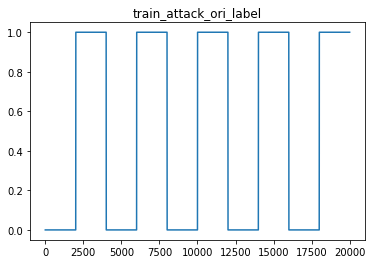

Epoch 1/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6932 - acc: 0.5007
Epoch 2/20
20000/20000 [==============================] - 0s 12us/step - loss: 0.6932 - acc: 0.5031
Epoch 3/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6932 - acc: 0.5007
Epoch 4/20
20000/20000 [==============================] - 0s 12us/step - loss: 0.6931 - acc: 0.5073
Epoch 5/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6932 - acc: 0.5038
Epoch 6/20
20000/20000 [==============================] - 0s 12us/step - loss: 0.6932 - acc: 0.5005
Epoch 7/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6931 - acc: 0.5071
Epoch 8/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6932 - acc: 0.5012
Epoch 9/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6931 - acc: 0.5052
Epoch 10/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6932 - acc: 0.4975

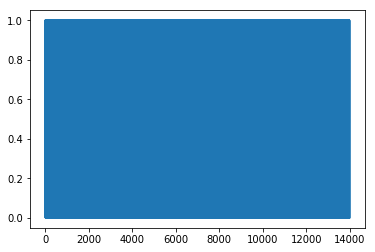

7000/7000 [==============================] - 0s 11us/step
Test loss: 0.6921826231820243
Test accuracy: 0.549
7000/7000 [==============================] - 0s 9us/step
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]
(2711, 28, 28, 1)
(2711, 10)
(2711, 1)
{'fn': 3066, 'tp': 777, 'tn': 1223, 'fp': 1934}


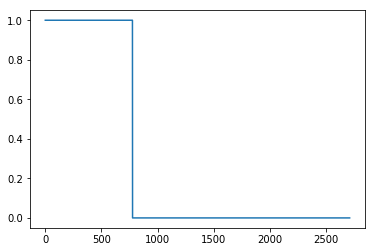

Epoch 1/100
2711/2711 [==============================] - 1s 185us/step - loss: 2.7513 - acc: 0.2372
Epoch 2/100
2711/2711 [==============================] - 1s 193us/step - loss: 1.5873 - acc: 0.2774
Epoch 3/100
2711/2711 [==============================] - 1s 193us/step - loss: 1.4945 - acc: 0.3043
Epoch 4/100
2711/2711 [==============================] - 1s 193us/step - loss: 1.4168 - acc: 0.3294
Epoch 5/100
2711/2711 [==============================] - 1s 196us/step - loss: 1.3584 - acc: 0.3549
Epoch 6/100
2711/2711 [==============================] - 1s 191us/step - loss: 1.3141 - acc: 0.3814
Epoch 7/100
2711/2711 [==============================] - 1s 190us/step - loss: 1.2887 - acc: 0.4087
Epoch 8/100
2711/2711 [==============================] - 1s 192us/step - loss: 1.2268 - acc: 0.4485
Epoch 9/100
2711/2711 [==============================] - 1s 189us/step - loss: 1.1948 - acc: 0.4581
Epoch 10/100
2711/2711 [==============================] - 1s 198us/step - loss: 1.1510 - acc: 0.4840

2711/2711 [==============================] - 1s 190us/step - loss: 0.0817 - acc: 0.9753
Epoch 83/100
2711/2711 [==============================] - 1s 193us/step - loss: 0.0849 - acc: 0.9786
Epoch 84/100
2711/2711 [==============================] - 1s 190us/step - loss: 0.0829 - acc: 0.9771
Epoch 85/100
2711/2711 [==============================] - 1s 200us/step - loss: 0.0787 - acc: 0.9790
Epoch 86/100
2711/2711 [==============================] - 1s 196us/step - loss: 0.0761 - acc: 0.9782
Epoch 87/100
2711/2711 [==============================] - 1s 195us/step - loss: 0.0768 - acc: 0.9805
Epoch 88/100
2711/2711 [==============================] - 1s 196us/step - loss: 0.0766 - acc: 0.9816
Epoch 89/100
2711/2711 [==============================] - 1s 193us/step - loss: 0.0716 - acc: 0.9808
Epoch 90/100
2711/2711 [==============================] - 1s 197us/step - loss: 0.0771 - acc: 0.9790
Epoch 91/100
2711/2711 [==============================] - 1s 192us/step - loss: 0.0737 - acc: 0.9782
Epo

2711/2711 [==============================] - 1s 187us/step - loss: 0.1269 - acc: 0.9620
Epoch 64/100
2711/2711 [==============================] - 1s 185us/step - loss: 0.1312 - acc: 0.9605
Epoch 65/100
2711/2711 [==============================] - 1s 187us/step - loss: 0.1013 - acc: 0.9727
Epoch 66/100
2711/2711 [==============================] - 1s 188us/step - loss: 0.1219 - acc: 0.9587
Epoch 67/100
2711/2711 [==============================] - 1s 191us/step - loss: 0.1227 - acc: 0.9627
Epoch 68/100
2711/2711 [==============================] - 1s 194us/step - loss: 0.1012 - acc: 0.9723
Epoch 69/100
2711/2711 [==============================] - 1s 192us/step - loss: 0.1120 - acc: 0.9686
Epoch 70/100
2711/2711 [==============================] - 1s 190us/step - loss: 0.0971 - acc: 0.9723
Epoch 71/100
2711/2711 [==============================] - 1s 197us/step - loss: 0.0905 - acc: 0.9753
Epoch 72/100
2711/2711 [==============================] - 1s 192us/step - loss: 0.0943 - acc: 0.9749
Epo

2711/2711 [==============================] - 1s 192us/step - loss: 0.2240 - acc: 0.9277
Epoch 45/100
2711/2711 [==============================] - 1s 193us/step - loss: 0.2039 - acc: 0.9388
Epoch 46/100
2711/2711 [==============================] - 1s 191us/step - loss: 0.2057 - acc: 0.9362
Epoch 47/100
2711/2711 [==============================] - 1s 186us/step - loss: 0.1966 - acc: 0.9377
Epoch 48/100
2711/2711 [==============================] - 1s 189us/step - loss: 0.1865 - acc: 0.9402
Epoch 49/100
2711/2711 [==============================] - 1s 191us/step - loss: 0.1768 - acc: 0.9454
Epoch 50/100
2711/2711 [==============================] - 1s 193us/step - loss: 0.1783 - acc: 0.9458
Epoch 51/100
2711/2711 [==============================] - 1s 194us/step - loss: 0.1504 - acc: 0.9543
Epoch 52/100
2711/2711 [==============================] - 1s 191us/step - loss: 0.1610 - acc: 0.9502
Epoch 53/100
2711/2711 [==============================] - 1s 192us/step - loss: 0.1547 - acc: 0.9535
Epo

2711/2711 [==============================] - 0s 184us/step - loss: 0.5774 - acc: 0.7794
Epoch 26/100
2711/2711 [==============================] - 1s 194us/step - loss: 0.5419 - acc: 0.7953
Epoch 27/100
2711/2711 [==============================] - 1s 195us/step - loss: 0.4971 - acc: 0.8156
Epoch 28/100
2711/2711 [==============================] - 1s 192us/step - loss: 0.4881 - acc: 0.8215
Epoch 29/100
2711/2711 [==============================] - 1s 193us/step - loss: 0.4659 - acc: 0.8266
Epoch 30/100
2711/2711 [==============================] - 1s 192us/step - loss: 0.4285 - acc: 0.8454
Epoch 31/100
2711/2711 [==============================] - 1s 190us/step - loss: 0.4260 - acc: 0.8425
Epoch 32/100
2711/2711 [==============================] - 1s 205us/step - loss: 0.3808 - acc: 0.8657
Epoch 33/100
2711/2711 [==============================] - 1s 195us/step - loss: 0.3671 - acc: 0.8702
Epoch 34/100
2711/2711 [==============================] - 1s 194us/step - loss: 0.3586 - acc: 0.8709
Epo

Epoch 6/100
2711/2711 [==============================] - 1s 192us/step - loss: 1.3272 - acc: 0.3648
Epoch 7/100
2711/2711 [==============================] - 1s 185us/step - loss: 1.2925 - acc: 0.3884
Epoch 8/100
2711/2711 [==============================] - 1s 192us/step - loss: 1.2323 - acc: 0.4319
Epoch 9/100
2711/2711 [==============================] - 1s 191us/step - loss: 1.1939 - acc: 0.4552
Epoch 10/100
2711/2711 [==============================] - 1s 191us/step - loss: 1.1591 - acc: 0.4795
Epoch 11/100
2711/2711 [==============================] - 1s 186us/step - loss: 1.1246 - acc: 0.4976
Epoch 12/100
2711/2711 [==============================] - 1s 194us/step - loss: 1.0665 - acc: 0.5374
Epoch 13/100
2711/2711 [==============================] - 1s 193us/step - loss: 1.0315 - acc: 0.5474
Epoch 14/100
2711/2711 [==============================] - 1s 192us/step - loss: 0.9951 - acc: 0.5780
Epoch 15/100
2711/2711 [==============================] - 1s 189us/step - loss: 0.9465 - acc: 0

2711/2711 [==============================] - 1s 197us/step - loss: 0.0905 - acc: 0.9749
Epoch 88/100
2711/2711 [==============================] - 1s 187us/step - loss: 0.0769 - acc: 0.9775
Epoch 89/100
2711/2711 [==============================] - 1s 191us/step - loss: 0.0862 - acc: 0.9749
Epoch 90/100
2711/2711 [==============================] - 1s 188us/step - loss: 0.0834 - acc: 0.9782
Epoch 91/100
2711/2711 [==============================] - 1s 192us/step - loss: 0.0725 - acc: 0.9805
Epoch 92/100
2711/2711 [==============================] - 1s 193us/step - loss: 0.0729 - acc: 0.9830
Epoch 93/100
2711/2711 [==============================] - 1s 196us/step - loss: 0.0671 - acc: 0.9830
Epoch 94/100
2711/2711 [==============================] - 1s 190us/step - loss: 0.0715 - acc: 0.9830
Epoch 95/100
2711/2711 [==============================] - 1s 191us/step - loss: 0.0682 - acc: 0.9827
Epoch 96/100
2711/2711 [==============================] - 1s 196us/step - loss: 0.0656 - acc: 0.9849
Epo

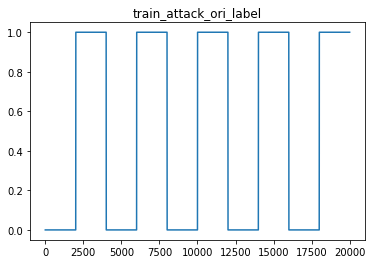

Epoch 1/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6930 - acc: 0.5116
Epoch 2/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6933 - acc: 0.5007
Epoch 3/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6931 - acc: 0.5107
Epoch 4/20
20000/20000 [==============================] - 0s 12us/step - loss: 0.6931 - acc: 0.5052
Epoch 5/20
20000/20000 [==============================] - 0s 12us/step - loss: 0.6932 - acc: 0.5028
Epoch 6/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6931 - acc: 0.5078
Epoch 7/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6932 - acc: 0.5025
Epoch 8/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6931 - acc: 0.5050
Epoch 9/20
20000/20000 [==============================] - 0s 13us/step - loss: 0.6930 - acc: 0.5041
Epoch 10/20
20000/20000 [==============================] - 0s 12us/step - loss: 0.6930 - acc: 0.5096

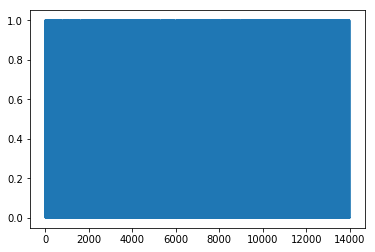

7000/7000 [==============================] - 0s 13us/step
Test loss: 0.692083680493491
Test accuracy: 0.6361428571428571
7000/7000 [==============================] - 0s 7us/step
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]
(1353, 28, 28, 1)
(1353, 10)
(1353, 1)
{'fn': 4050, 'tp': 403, 'tn': 1597, 'fp': 950}


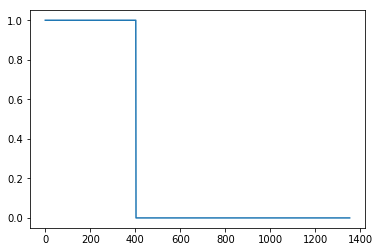

Epoch 1/100
1353/1353 [==============================] - 0s 205us/step - loss: 2.9035 - acc: 0.4590
Epoch 2/100
1353/1353 [==============================] - 0s 186us/step - loss: 1.1885 - acc: 0.5551
Epoch 3/100
1353/1353 [==============================] - 0s 196us/step - loss: 0.8425 - acc: 0.5802
Epoch 4/100
1353/1353 [==============================] - 0s 192us/step - loss: 0.7470 - acc: 0.6282
Epoch 5/100
1353/1353 [==============================] - 0s 196us/step - loss: 0.6777 - acc: 0.6534
Epoch 6/100
1353/1353 [==============================] - 0s 200us/step - loss: 0.6290 - acc: 0.6704
Epoch 7/100
1353/1353 [==============================] - 0s 200us/step - loss: 0.6033 - acc: 0.7073
Epoch 8/100
1353/1353 [==============================] - 0s 190us/step - loss: 0.5455 - acc: 0.7421
Epoch 9/100
1353/1353 [==============================] - 0s 200us/step - loss: 0.5232 - acc: 0.7598
Epoch 10/100
1353/1353 [==============================] - 0s 200us/step - loss: 0.4704 - acc: 0.7916

Epoch 82/100
1353/1353 [==============================] - 0s 234us/step - loss: 0.0338 - acc: 0.9956
Epoch 83/100
1353/1353 [==============================] - 0s 322us/step - loss: 0.0412 - acc: 0.9933
Epoch 84/100
1353/1353 [==============================] - 1s 428us/step - loss: 0.0443 - acc: 0.9941
Epoch 85/100
1353/1353 [==============================] - 1s 448us/step - loss: 0.0384 - acc: 0.9948 0s - loss: 0.0393 - acc: 0.
Epoch 86/100
1353/1353 [==============================] - 0s 315us/step - loss: 0.0360 - acc: 0.9963
Epoch 87/100
1353/1353 [==============================] - 0s 232us/step - loss: 0.0452 - acc: 0.9919
Epoch 88/100
1353/1353 [==============================] - 0s 231us/step - loss: 0.0395 - acc: 0.9941
Epoch 89/100
1353/1353 [==============================] - 1s 462us/step - loss: 0.0315 - acc: 0.9963 0s - loss: 0.0347 - acc:
Epoch 90/100
1353/1353 [==============================] - 0s 312us/step - loss: 0.0356 - acc: 0.9963
Epoch 91/100
1353/1353 [==============

1353/1353 [==============================] - 0s 212us/step - loss: 0.0440 - acc: 0.9933
Epoch 63/100
1353/1353 [==============================] - 0s 215us/step - loss: 0.0410 - acc: 0.9948
Epoch 64/100
1353/1353 [==============================] - 0s 215us/step - loss: 0.0528 - acc: 0.9874
Epoch 65/100
1353/1353 [==============================] - 0s 211us/step - loss: 0.0489 - acc: 0.9897
Epoch 66/100
1353/1353 [==============================] - 0s 202us/step - loss: 0.0393 - acc: 0.9948
Epoch 67/100
1353/1353 [==============================] - 0s 208us/step - loss: 0.0667 - acc: 0.9911
Epoch 68/100
1353/1353 [==============================] - 0s 208us/step - loss: 0.0467 - acc: 0.9941
Epoch 69/100
1353/1353 [==============================] - 0s 219us/step - loss: 0.0517 - acc: 0.9926
Epoch 70/100
1353/1353 [==============================] - 0s 208us/step - loss: 0.0376 - acc: 0.9956
Epoch 71/100
1353/1353 [==============================] - 0s 208us/step - loss: 0.0505 - acc: 0.9911
Epo

1353/1353 [==============================] - 0s 213us/step - loss: 0.0660 - acc: 0.9874
Epoch 44/100
1353/1353 [==============================] - 0s 215us/step - loss: 0.0697 - acc: 0.9867
Epoch 45/100
1353/1353 [==============================] - 0s 218us/step - loss: 0.0731 - acc: 0.9852
Epoch 46/100
1353/1353 [==============================] - 0s 206us/step - loss: 0.0644 - acc: 0.9852
Epoch 47/100
1353/1353 [==============================] - 0s 210us/step - loss: 0.0723 - acc: 0.9830
Epoch 48/100
1353/1353 [==============================] - 0s 219us/step - loss: 0.0674 - acc: 0.9860
Epoch 49/100
1353/1353 [==============================] - 0s 208us/step - loss: 0.0573 - acc: 0.9889
Epoch 50/100
1353/1353 [==============================] - 0s 208us/step - loss: 0.0603 - acc: 0.9911
Epoch 51/100
1353/1353 [==============================] - 0s 201us/step - loss: 0.0641 - acc: 0.9882
Epoch 52/100
1353/1353 [==============================] - 0s 221us/step - loss: 0.0572 - acc: 0.9889
Epo

1353/1353 [==============================] - 0s 233us/step - loss: 0.1933 - acc: 0.9320
Epoch 24/100
1353/1353 [==============================] - 0s 221us/step - loss: 0.1686 - acc: 0.9438
Epoch 25/100
1353/1353 [==============================] - 0s 208us/step - loss: 0.1678 - acc: 0.9424
Epoch 26/100
1353/1353 [==============================] - 0s 219us/step - loss: 0.1442 - acc: 0.9593
Epoch 27/100
1353/1353 [==============================] - 0s 219us/step - loss: 0.1554 - acc: 0.9483
Epoch 28/100
1353/1353 [==============================] - 0s 221us/step - loss: 0.1455 - acc: 0.9520
Epoch 29/100
1353/1353 [==============================] - 0s 208us/step - loss: 0.1426 - acc: 0.9564
Epoch 30/100
1353/1353 [==============================] - 0s 219us/step - loss: 0.1123 - acc: 0.9719
Epoch 31/100
1353/1353 [==============================] - 0s 210us/step - loss: 0.1084 - acc: 0.9712
Epoch 32/100
1353/1353 [==============================] - 0s 219us/step - loss: 0.1075 - acc: 0.9675
Epo

1353/1353 [==============================] - 0s 254us/step - loss: 0.7679 - acc: 0.6305
Epoch 5/100
1353/1353 [==============================] - 0s 231us/step - loss: 0.7004 - acc: 0.6785
Epoch 6/100
1353/1353 [==============================] - 0s 232us/step - loss: 0.6274 - acc: 0.6844
Epoch 7/100
1353/1353 [==============================] - 0s 217us/step - loss: 0.5960 - acc: 0.7251
Epoch 8/100
1353/1353 [==============================] - 0s 220us/step - loss: 0.5281 - acc: 0.7568
Epoch 9/100
1353/1353 [==============================] - 0s 220us/step - loss: 0.4823 - acc: 0.7753
Epoch 10/100
1353/1353 [==============================] - 0s 214us/step - loss: 0.4421 - acc: 0.8041
Epoch 11/100
1353/1353 [==============================] - 0s 219us/step - loss: 0.4522 - acc: 0.7901
Epoch 12/100
1353/1353 [==============================] - 0s 215us/step - loss: 0.3825 - acc: 0.8396
Epoch 13/100
1353/1353 [==============================] - 0s 219us/step - loss: 0.3458 - acc: 0.8596
Epoch 14

1353/1353 [==============================] - 0s 225us/step - loss: 0.0323 - acc: 0.9970
Epoch 86/100
1353/1353 [==============================] - 0s 266us/step - loss: 0.0317 - acc: 0.9963
Epoch 87/100
1353/1353 [==============================] - 0s 221us/step - loss: 0.0419 - acc: 0.9933
Epoch 88/100
1353/1353 [==============================] - 0s 285us/step - loss: 0.0372 - acc: 0.9933
Epoch 89/100
1353/1353 [==============================] - 0s 231us/step - loss: 0.0337 - acc: 0.9948
Epoch 90/100
1353/1353 [==============================] - 0s 231us/step - loss: 0.0284 - acc: 0.9978
Epoch 91/100
1353/1353 [==============================] - 0s 219us/step - loss: 0.0330 - acc: 0.9948
Epoch 92/100
1353/1353 [==============================] - 0s 209us/step - loss: 0.0331 - acc: 0.9956
Epoch 93/100
1353/1353 [==============================] - 0s 231us/step - loss: 0.0352 - acc: 0.9941
Epoch 94/100
1353/1353 [==============================] - 0s 219us/step - loss: 0.0324 - acc: 0.9963
Epo

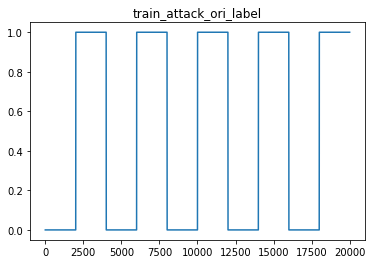

Epoch 1/20
20000/20000 [==============================] - 0s 16us/step - loss: 0.6931 - acc: 0.5070
Epoch 2/20
20000/20000 [==============================] - 0s 18us/step - loss: 0.6932 - acc: 0.5048
Epoch 3/20
20000/20000 [==============================] - 0s 21us/step - loss: 0.6931 - acc: 0.5071
Epoch 4/20
20000/20000 [==============================] - 0s 15us/step - loss: 0.6932 - acc: 0.4998
Epoch 5/20
20000/20000 [==============================] - 0s 15us/step - loss: 0.6932 - acc: 0.5018
Epoch 6/20
20000/20000 [==============================] - 0s 14us/step - loss: 0.6931 - acc: 0.5012
Epoch 7/20
20000/20000 [==============================] - 0s 18us/step - loss: 0.6932 - acc: 0.4977
Epoch 8/20
20000/20000 [==============================] - 1s 31us/step - loss: 0.6931 - acc: 0.5056
Epoch 9/20
20000/20000 [==============================] - 1s 37us/step - loss: 0.6931 - acc: 0.4993
Epoch 10/20
20000/20000 [==============================] - 1s 32us/step - loss: 0.6932 - acc: 0.4966

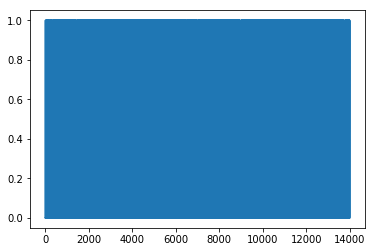

In [14]:
for i in range (0,distil_index):
    feature_membership_temp = target_model.predict(distil_data[i],verbose=1)



    #步骤7、8，将得到的软标签过一遍attack得到第二标签
    score = attack_model.evaluate(feature_membership_temp,label_membership_temp,verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    predict_membership_temp = attack_model.predict_classes(feature_membership_temp,verbose=1)
    print(label_membership_temp)

    
    #记录混淆矩阵
    confus = {'tp':0,'fp':0,'tn':0,'fn':0}

    ori_membership_temp_positive = []
    feature_membership_temp_positive = []
    predict_membership_temp_positive = []

    for i in range(0,len(label_membership_temp)):
        if predict_membership_temp[i] == 1:
            ori_membership_temp_positive.append(distil_data[0][i])
            feature_membership_temp_positive.append(feature_membership_temp[i])
            predict_membership_temp_positive.append(label_membership_temp[i])
            if label_membership_temp[i] == 1:
                confus['tp'] += 1
            elif label_membership_temp[i] == 0:
                confus['fp'] += 1
        elif predict_membership_temp[i] == 0:
            if label_membership_temp[i] == 1:
                confus['tn'] += 1
            elif label_membership_temp[i] == 0:
                confus['fn'] += 1

    ori_membership_temp_positive = np.array(ori_membership_temp_positive)
    feature_membership_temp_positive = np.array(feature_membership_temp_positive)
    predict_membership_temp_positive = np.array(predict_membership_temp_positive)
    print(ori_membership_temp_positive.shape)
    print(feature_membership_temp_positive.shape)
    print(predict_membership_temp_positive.shape)
    print(confus)
    
    plt.plot(predict_membership_temp_positive)
    plt.show()
    
    #步骤1，feature_membership_temp_positive就是第二标签为1的数据过一遍target得到软标签
    ones_menbership_temp_positive = np.ones((len(feature_membership_temp_positive),1))
    
    #步骤2，加入数据继续训练5个shadow模型
    ori_membership_temp_positive = ori_membership_temp_positive.reshape(-1,28 * 28)
    for i in range(0,len(models)):
        models[i].fit(ori_membership_temp_positive,feature_membership_temp_positive,batch_size = 64,epochs = 100,verbose=1)
        
    #3、4 用测试数据分别过一遍5个shadow，并贴标签用作attack模型的训练
    x_train,y_train,x_test,y_test = load_mnist_data()
    start_indexs = [0,2000,4000,6000,8000]
    
    #生成5个shadow测试数据的ori,
    shadow_x_ori = []
    shadow_y_ori = []

    for start_index in start_indexs:
        shadow_x_ori_sub = x_train[start_index:start_index + 2000]
        for i in range(1,6):
            left = i * 10000 + start_index
            shadow_x_ori_sub = np.concatenate((shadow_x_ori_sub,x_train[left:left + 2000]), axis=0)
        shadow_x_ori_sub = np.concatenate((shadow_x_ori_sub,x_test[start_index:start_index + 2000]), axis=0)
        shadow_x_ori.append(shadow_x_ori_sub)

        shadow_y_ori_sub = y_train[start_index:start_index + 2000]
        for i in range(1,6):
            left = i * 10000 + start_index
            shadow_y_ori_sub = np.concatenate((shadow_y_ori_sub,y_train[left:left + 2000]), axis=0)
        shadow_y_ori_sub = np.concatenate((shadow_y_ori_sub,y_test[start_index:start_index + 2000]), axis=0)
        shadow_y_ori.append(shadow_test_y)
    print(shadow_x_ori[0].shape)
    
    #5再次训练attack模型
    shadow_train_x,shadow_train_y = load_shadow_train_data(shadow_x_ori)
    shadow_train_x = target_model.predict(shadow_train_x,verbose=1)
    print(shadow_train_x.shape)
    print(shadow_train_y.shape)
    plt.title('train_attack_ori_label')
    plt.plot(shadow_train_y)
    plt.show()
    attack_model.fit(shadow_train_x, shadow_train_y,nb_epoch=20, batch_size=64,verbose=1)
    
    #模型评估
    x_train,y_train,x_test,y_test = load_mnist_data()
    
    #选择测试集
    start_index = 8000
    shadow_test_x = x_train[start_index:start_index + 2000]
    for i in range(1,6):
        left = i * 10000 + start_index
        shadow_test_x = np.concatenate((shadow_test_x,x_train[left:left + 2000]), axis=0)
    shadow_test_x = np.concatenate((shadow_test_x,x_test[start_index:start_index + 2000]), axis=0)

    shadow_test_y = y_train[start_index:start_index + 2000]
    for i in range(1,6):
        left = i * 10000 + start_index
        shadow_test_y = np.concatenate((shadow_test_y,y_train[left:left + 2000]), axis=0)
    shadow_test_y = np.concatenate((shadow_test_y,y_test[start_index:start_index + 2000]), axis=0)
    
    
    shadow_label = np.ones((2000,1))
    shadow_label = np.concatenate((shadow_label,np.zeros((12000,1))), axis=0)
    last_x = target_model.predict(shadow_test_x,verbose=1)
    
    score = attack_model.evaluate(last_x[8000:12000],shadow_label[8000:12000],verbose=1)
    print('Percent:0%')
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    
    score = attack_model.evaluate(last_x[3200:7200],shadow_label[3200:7200],verbose=1)
    print('Percent:20%')
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    
    score = attack_model.evaluate(last_x[0:4000],shadow_label[0:4000],verbose=1)
    print('Percent:50%')
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    
    score = attack_model.evaluate(last_x[0:2000],shadow_label[0:2000],verbose=1)
    print('Percent:100%')
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    
    predict = attack_model.predict_classes(last_x,verbose=1)
    plt.plot(predict)
    plt.show()